# RandomForest Modeling for Mail Marketing

### Importing necesaary packages (including Snowpark)
If any of the packages do not exist in your Python environment you can install them using conda. Here is an example of installing seaborn visualization package

preparation:
Packages:
1. SnowPark
2. Seaborn
3. json
4. sklearn
5. pandas
6. matplot

Tools: Anaconda

In [81]:
# Snowpark
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.functions import pandas_udf

# Pandas & json
import pandas as pd
import numpy as np
import json

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

### Set Snowflake Context

#### Session connect 

In [92]:
# Read credentials
with open('creds.json') as f:
    connection_parameters = json.load(f)    
session = Session.builder.configs(connection_parameters).create()

In [93]:
snowpark_version = VERSION
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Role                        : {}'.format(session.get_current_role()))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

Database                    : "MARKETING_MAIL"
Schema                      : "PUBLIC"
Warehouse                   : "MARKETINGMAIL_WH"
Role                        : "ACCOUNTADMIN"
Snowpark for Python version : 1.0.0


In [4]:
customerInfo = pd.read_csv("DirectMarketing.csv")
customerInfo.head(5)

,Age,Gender,OwnHome,Married,Location,Salary,Children,History,Catalogs,AmountSpent
0,Old,Female,Own,Single,Far,47500,0,High,6,755
1,Middle,Male,Rent,Single,Close,63600,0,High,6,1318
2,Young,Female,Rent,Single,Close,13500,0,Low,18,296
3,Middle,Male,Own,Married,Close,85600,1,High,18,2436
4,Middle,Female,Own,Single,Close,68400,0,High,12,1304


In [5]:
customerInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Age          1000 non-null   object
 1   Gender       1000 non-null   object
 2   OwnHome      1000 non-null   object
 3   Married      1000 non-null   object
 4   Location     1000 non-null   object
 5   Salary       1000 non-null   int64 
 6   Children     1000 non-null   int64 
 7   History      697 non-null    object
 8   Catalogs     1000 non-null   int64 
 9   AmountSpent  1000 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


### Upload Data to Snowflake

In [6]:
# Create snowflake dataframe in the snowflake
snowdf = session.createDataFrame(customerInfo)

create_temp_table is deprecated. We still respect this parameter when it is True but please consider using `table_type="temporary"` instead.


In [7]:
snowdf.show(5)

---------------------------------------------------------------------------------------------------------------------------
|"Age"   |"Gender"  |"OwnHome"  |"Married"  |"Location"  |"Salary"  |"Children"  |"History"  |"Catalogs"  |"AmountSpent"  |
---------------------------------------------------------------------------------------------------------------------------
|Old     |Female    |Own        |Single     |Far         |47500     |0           |High       |6           |755            |
|Middle  |Male      |Rent       |Single     |Close       |63600     |0           |High       |6           |1318           |
|Young   |Female    |Rent       |Single     |Close       |13500     |0           |Low        |18          |296            |
|Middle  |Male      |Own        |Married    |Close       |85600     |1           |High       |18          |2436           |
|Middle  |Female    |Own        |Single     |Close       |68400     |0           |High       |12          |1304           |
--------

In [8]:
snowdf.write.mode("overwrite").saveAsTable("CUSTOMERS_INFO") 

session.table("CUSTOMERS_INFO").limit(3).show(5)

---------------------------------------------------------------------------------------------------------------------------
|"Age"   |"Gender"  |"OwnHome"  |"Married"  |"Location"  |"Salary"  |"Children"  |"History"  |"Catalogs"  |"AmountSpent"  |
---------------------------------------------------------------------------------------------------------------------------
|Old     |Female    |Own        |Single     |Far         |47500     |0           |High       |6           |755            |
|Middle  |Male      |Rent       |Single     |Close       |63600     |0           |High       |6           |1318           |
|Young   |Female    |Rent       |Single     |Close       |13500     |0           |Low        |18          |296            |
---------------------------------------------------------------------------------------------------------------------------



In [56]:
# Create a pandas data frame from the Snowflake table
# set the dataframe format for the table we is going to upload
custdf = session.table('CUSTOMERS_INFO').toPandas() 
print(f"'custdf' local dataframe created. Number of records: {len(custdf)} ")

'custdf' local dataframe created. Number of records: 1000 


In [57]:
custdf.head(5)

,Age,Gender,OwnHome,Married,Location,Salary,Children,History,Catalogs,AmountSpent
0,Old,Female,Own,Single,Far,47500,0,High,6,755
1,Middle,Male,Rent,Single,Close,63600,0,High,6,1318
2,Young,Female,Rent,Single,Close,13500,0,Low,18,296
3,Middle,Male,Own,Married,Close,85600,1,High,18,2436
4,Middle,Female,Own,Single,Close,68400,0,High,12,1304


<AxesSubplot: title={'center': 'Encoded Correlation Heatmap for Used Mail Marketing Dataset'}>

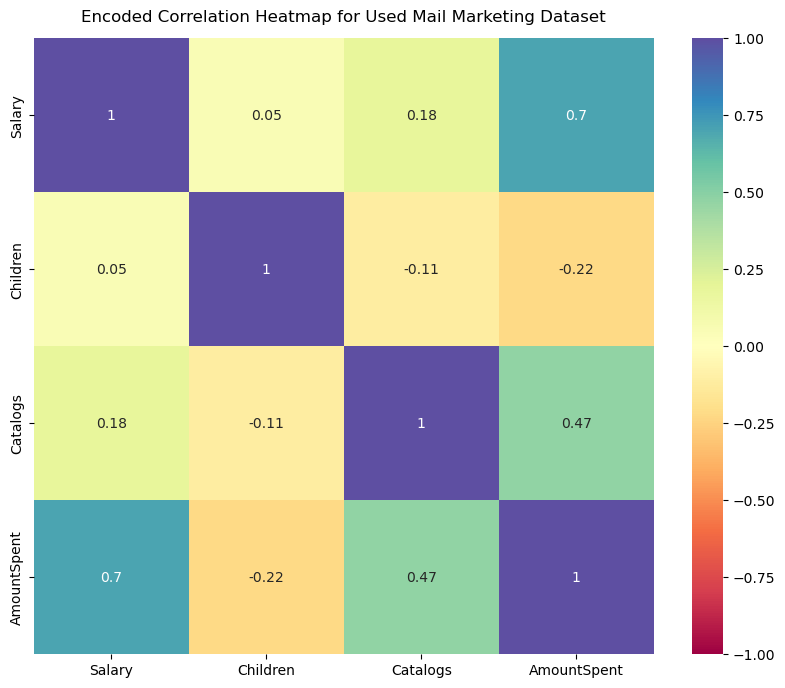

In [11]:
# Start by understanding the correlation matrix for the new data frame
f, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Encoded Correlation Heatmap for Used Mail Marketing Dataset', pad=12)
sns.heatmap(custdf.corr(), vmin=-1, vmax=1, annot=True, cmap='Spectral')

### Select Feature
Based on the former Data Analysis, we would choose: Age, Gender, OwnHome, Location, Salary, Children, Catalogs as input features.

Since we have a lot of categorical data, we need to transform them into numeric type

In [58]:
custdf.head(5)

,Age,Gender,OwnHome,Married,Location,Salary,Children,History,Catalogs,AmountSpent
0,Old,Female,Own,Single,Far,47500,0,High,6,755
1,Middle,Male,Rent,Single,Close,63600,0,High,6,1318
2,Young,Female,Rent,Single,Close,13500,0,Low,18,296
3,Middle,Male,Own,Married,Close,85600,1,High,18,2436
4,Middle,Female,Own,Single,Close,68400,0,High,12,1304


### Data Processing 

Here we transform the data format in the table since we want to use the RandomForest algorithm 

In [59]:
# Transform 
def age_label(e):
    if e == 'Young':
        return 1
    if e == 'Middle':
        return 2
    else:
        return 3;

def gender_label(e):
    if e == 'Female':
        return 1
    else:
        return 2
    
def ownHome_label(e):
    if e == 'own':
        return 1
    else:
        return 2

def location_label(e):
    if e == 'close':
        return 1
    else:
        return 2

def history_label(e):
    if e == 'high':
        return 1
    if e == 'low':
        return 2
    else:
        return 0

In [60]:
custdf["Age"] = custdf["Age"].apply(age_label)
#custdf["Age_Group"] = custdf["Age"]
custdf["Gender"] = custdf["Gender"].apply(gender_label)
custdf["OwnHome"] = custdf["OwnHome"].apply(ownHome_label)
custdf["Location"] = custdf["Location"].apply(location_label)
custdf["History"] = custdf["History"].apply(history_label)

In [61]:
custdf.head(5)

,Age,Gender,OwnHome,Married,Location,Salary,Children,History,Catalogs,AmountSpent
0,3,1,2,Single,2,47500,0,0,6,755
1,2,2,2,Single,2,63600,0,0,6,1318
2,1,1,2,Single,2,13500,0,0,18,296
3,2,2,2,Married,2,85600,1,0,18,2436
4,2,1,2,Single,2,68400,0,0,12,1304


In [64]:
custdf.rename(columns={'Gender':'GENDER', 'OwnHome':'OWNHOME','Location':'LOCATION',
                      'Married':'MARRIED','Salary':'SALARY','Children':'CHILDREN',
                       'History':'HISTORY','Catalogs':'CATALOGS','AmountSpent':'AMOUNTSPEND'
                       ,'Age':'AGE'}, 
                      inplace = True)

In [65]:
#custdf = custdf.drop(['Age'], axis=1)
custdf.head(5)

,AGE,GENDER,OWNHOME,MARRIED,LOCATION,SALARY,CHILDREN,HISTORY,CATALOGS,AMOUNTSPEND
0,3,1,2,Single,2,47500,0,0,6,755
1,2,2,2,Single,2,63600,0,0,6,1318
2,1,1,2,Single,2,13500,0,0,18,296
3,2,2,2,Married,2,85600,1,0,18,2436
4,2,1,2,Single,2,68400,0,0,12,1304


In [66]:
snowcustdf = session.createDataFrame(custdf)
snowcustdf.show()

--------------------------------------------------------------------------------------------------------------------------
|"AGE"  |"GENDER"  |"OWNHOME"  |"MARRIED"  |"LOCATION"  |"SALARY"  |"CHILDREN"  |"HISTORY"  |"CATALOGS"  |"AMOUNTSPEND"  |
--------------------------------------------------------------------------------------------------------------------------
|3      |1         |2          |Single     |2           |47500     |0           |0          |6           |755            |
|2      |2         |2          |Single     |2           |63600     |0           |0          |6           |1318           |
|1      |1         |2          |Single     |2           |13500     |0           |0          |18          |296            |
|2      |2         |2          |Married    |2           |85600     |1           |0          |18          |2436           |
|2      |1         |2          |Single     |2           |68400     |0           |0          |12          |1304           |
|1      |2      

In [67]:
snowcustdf.write.mode("overwrite").saveAsTable("customers_info_new") 
session.table("CUSTOMERS_INFO_NEW").limit(3).show(5)

--------------------------------------------------------------------------------------------------------------------------
|"AGE"  |"GENDER"  |"OWNHOME"  |"MARRIED"  |"LOCATION"  |"SALARY"  |"CHILDREN"  |"HISTORY"  |"CATALOGS"  |"AMOUNTSPEND"  |
--------------------------------------------------------------------------------------------------------------------------
|3      |1         |2          |Single     |2           |47500     |0           |0          |6           |755            |
|2      |2         |2          |Single     |2           |63600     |0           |0          |6           |1318           |
|1      |1         |2          |Single     |2           |13500     |0           |0          |18          |296            |
--------------------------------------------------------------------------------------------------------------------------



In [69]:
custdf_new = session.table('CUSTOMERS_INFO_NEW').toPandas() 
print(f"'custdf_new' local dataframe created. Number of records: {len(custdf_new)} ")

'custdf_new' local dataframe created. Number of records: 1000 


### Split Dataset

In [70]:
# Define X and Y for modeling
X = custdf_new[['AGE', 'GENDER',
       'OWNHOME', 'LOCATION','SALARY','CHILDREN','HISTORY','CATALOGS']]
Y = custdf_new['AMOUNTSPEND']

In [71]:
# Split into training & Testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                 test_size=0.3, random_state=101)

### RandomForest Modeling

In [72]:
# Create an instance of RandomForest Regressor and Fit the training datasets
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor()

### Create RandomForest UDF

In [73]:
def predict_pandas_udf(df: pd.DataFrame) -> pd.Series:
    return pd.Series(rf.predict(df))  

rand_model_vec = pandas_udf(func=predict_pandas_udf,
                                return_type=FloatType(),
                                input_types=[IntegerType(),IntegerType(),IntegerType(),IntegerType(),
                                            IntegerType(),IntegerType(),IntegerType(),IntegerType()],
                                session=session,
                                packages = ("pandas","scikit-learn"), max_batch_size=200)

In [75]:
# Calling the UDF to do the scoring (pushing down to Snowflake)
output = session.table('CUSTOMERS_INFO_NEW').select(*list(X.columns),
                    rand_model_vec(list(X.columns)).alias('PREDICTED_SPEND'), 
                    (F.col('AMOUNTSPEND')).alias('ACTUAL_SPEND')
                    )

output.show(5)

-----------------------------------------------------------------------------------------------------------------------------------
|"AGE"  |"GENDER"  |"OWNHOME"  |"LOCATION"  |"SALARY"  |"CHILDREN"  |"HISTORY"  |"CATALOGS"  |"PREDICTED_SPEND"  |"ACTUAL_SPEND"  |
-----------------------------------------------------------------------------------------------------------------------------------
|3      |1         |2          |2           |47500     |0           |0          |6           |814.49             |755             |
|2      |2         |2          |2           |63600     |0           |0          |6           |1293.59            |1318            |
|1      |1         |2          |2           |13500     |0           |0          |18          |325.37             |296             |
|2      |2         |2          |2           |85600     |1           |0          |18          |2233.45            |2436            |
|2      |1         |2          |2           |68400     |0           |0      

### Save the predict result in the Snowflake

In [76]:
# Save the predicted output as a table on Snowflake
###used later in Streamlit app
output.write.mode("overwrite").saveAsTable("PREDICTED_CUSTOMER_SPENDING") 

# Also get a local dataframe to review the results
output=output.toPandas()

### Compare the results between Actual and predict from Snowflake

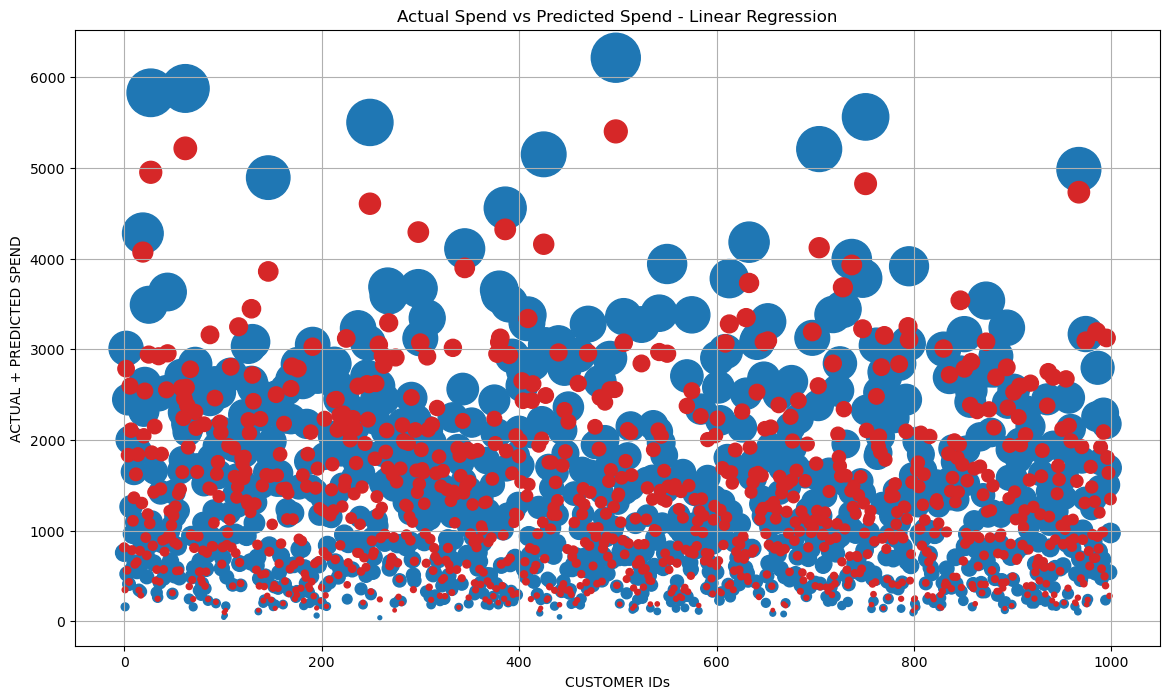

In [77]:
# Plot a descriptive scatter of predicted and actual values
x = output.index
y1 = output["ACTUAL_SPEND"]
y2 = output["PREDICTED_SPEND"]

f, ax = plt.subplots(figsize=(14, 8))
plt.scatter(x, y1, c='tab:blue', s=y1/5)
plt.scatter(x, y2, c='tab:red', s=y2/20)

plt.title(f"Actual Spend vs Predicted Spend - Linear Regression")
plt.ylabel("ACTUAL + PREDICTED SPEND")
plt.xlabel("CUSTOMER IDs")
ax.grid(True)
plt.show()

### Evaluate Model with Metrics

In [78]:
#1 & 2 Coefficient of Determination (R² & Adjusted R²)
print("\n--- Coefficient of Determination (R²) ---")
r2 = metrics.r2_score(y_pred=y2, y_true=y1)
print(f"R²: {round(r2, 2)}")

#3 & 4. MSE and RMSE
print("\n--- Mean Squared Error (MSE & RMSE) ---")

mse = metrics.mean_squared_error(y_pred=y2, y_true=y1, squared=True)
rmse = metrics.mean_squared_error(y_pred=y2, y_true=y1, squared=False)

print(f"MSE: {round(mse, 2)}")
print(f"RMSE: {round(rmse, 2)}")


#5. MAE
print("\n--- Mean Absolute Error (MAE) ---")
mae = metrics.mean_absolute_error(y_pred=y2, y_true=y1)
print(f"MAE: {round(mae, 2)}")



--- Coefficient of Determination (R²) ---
R²: 0.87

--- Mean Squared Error (MSE & RMSE) ---
MSE: 122164.66
RMSE: 349.52

--- Mean Absolute Error (MAE) ---
MAE: 224.65


In [79]:
coeff_df = pd.DataFrame(rf.feature_importances_,X.columns,columns=['Feature Importance']).round(2)
coeff_df

,Feature Importance
AGE,0.01
GENDER,0.02
OWNHOME,0.00
LOCATION,0.00
SALARY,0.73
CHILDREN,0.08
HISTORY,0.00
CATALOGS,0.15
